# Hankel method
Demonstrate how the Hankel transform method works.

Essentially we are running `frank` backwards; we create a radial profile given some disk parameters, convert it to visibilities with the discrete Hankel transform (which is just a matrix multiplication), and then compare it with visibilities that are deprojected given some disk inclination and PA. This comparison can yield a chi^2, which allows sampling.

In [15]:
import numpy as np
from scipy.stats import binned_statistic_2d
import scipy.fft
from scipy.special import jn_zeros
import matplotlib.pyplot as plt
# import galario.double as gd
import frank

import sys
sys.path.append('../src/vis_r')
import functions

First get some data and bin it in u,v space

In [2]:
visfiles = ['../data/hr4796.selfcal.npy']
# visfiles = ['/Users/grant/astro/data/alma/arks/HD131488/visibilities/HD131488.12mLB.npy',
#             '/Users/grant/astro/data/alma/arks/HD131488/visibilities/HD131488.12mSB.npy']

u_ = v_ = Re_ = Im_ = w_ = np.array([])
for i, f in enumerate(visfiles):
    u, v, Re, Im, w = functions.read_vis(f)
    print(f'loading: {f} with nvis:{len(u)}')

    reweight_factor = 2 * len(w) / np.sum((Re**2.0 + Im**2.0) * w)
    print(f' reweighting factor would be {reweight_factor}')

    u_ = np.append(u_, u)
    v_ = np.append(v_, v)
    w_ = np.append(w_, w)
    Re_ = np.append(Re_, Re)
    Im_ = np.append(Im_, Im)

loading: ../data/hr4796.selfcal.npy with nvis:321322
 reweighting factor would be 2.0716124238576996


In [3]:
np.min(np.sqrt(u_**2 + v_**2))

16001.951304384918

In [4]:
# this is the image/pixel size we would want if modelling with images
# gd.get_image_size(u, v)

In [229]:
sz = 4
data = {}

data['u'], data['v'], data['re'],  data['im'], data['w'] = \
    functions.bin_uv(u_, v_, Re_, Im_, w_, size_arcsec=sz)

data['nvis'] = len(data['u'])
data['sigma'] = 1/np.sqrt(data['w'])

print(f" original nvis:{len(u_)}, fitting nvis:{data['nvis']}")

u,v bin: 7348
 original nvis:321322, fitting nvis:19493


In [227]:
np.min(np.sqrt(data['u']**2 + data['v']**2))

16517.62931109068

Now deproject the visibilities given our assumed disk PA/inclination

In [228]:
inc = np.deg2rad(76.6)
PA = np.deg2rad(26.7)
# inc = np.deg2rad(97.26)
# PA = np.deg2rad(84.95)

_, ruv = functions.uv_trans(data['u'], data['v'], PA, inc)
urot, vrot = functions.uv_trans(data['u'], data['v'], PA, inc, return_uv=True)

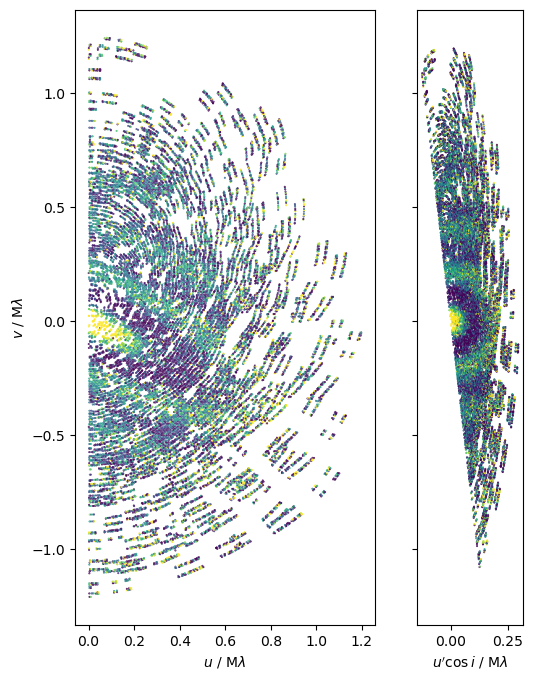

In [8]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6,7),
                       gridspec_kw={'width_ratios':[1, 0.3], 'height_ratios':[1]})
ax[0].scatter(data['u']/1e6, data['v']/1e6, c=data['re'], s=0.2, vmin=-0.005, vmax=0.01)
ax[1].scatter((urot*np.cos(inc))/1e6, vrot/1e6, c=data['re'], s=0.2, vmin=-0.005, vmax=0.01)
ax[0].set_xlabel('$u$ / M$\\lambda$')
ax[0].set_ylabel('$v$ / M$\\lambda$')
ax[1].set_xlabel('$u\' \\cos i$ / M$\\lambda$')
# ax[1].set_xlim(-0.2, 0.4)
for a in ax:
    # a.set_ylim(-1.3, 1.3)
    a.set_aspect('equal')
fig.tight_layout()
fig.subplots_adjust(wspace=-0.4, right=0.99, left=-0.1, bottom=0.1)
# fig.savefig('../doc/vis_avg.png', dpi=150)

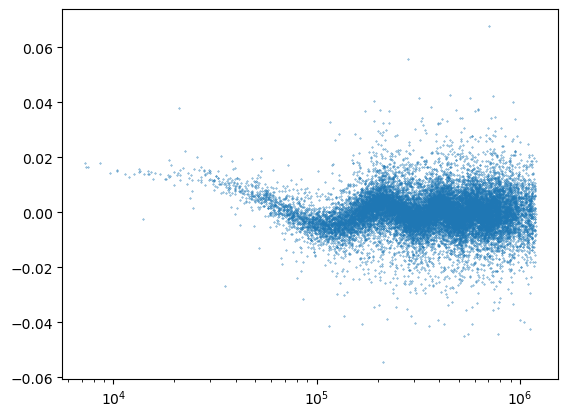

In [9]:
fig, ax = plt.subplots()
ax.scatter(ruv, data['re'], s=0.1)
ax.set_xscale('log')

Now get the Hankel object.

We don't actually need the transform matrix if we using python since `frank` has a method for the transform. We need to do it ourselves in `stan`.

In [ ]:
arcsec = np.pi/180/3600
uvmax = np.max(np.sqrt(data['u']**2 + data['v']**2))
uvmin = np.min(np.sqrt(data['u']**2 + data['v']**2))
# uvmin_ = uvmin/2  # extra to sample better near q_min
uvmin_ = get_duv(size_arcsec=sz)

# use simple criteria to set up q array
nq = int(uvmax/uvmin_)
q_max = uvmax
r_out = jn_zeros(0, nq+1)[-1] / (2*np.pi*uvmax) / arcsec
Qzero = np.arange(nq+1) * uvmin_ + uvmin_/2
Qzero = np.append(0, Qzero)

# set up transform, pre-computing new matrix for transform
nhpt = 300  # recommended by frank
h = frank.hankel.DiscreteHankelTransform(r_max*arcsec, nhpt)
Rnk, Qnk = h.get_collocation_points(r_max*arcsec, nhpt)

print(f'q points: {nq}, Hankel points: {nhpt}')
if 2*Qnk[0] > uvmin:
    print(f' WARNING: minimum Q not much smaller than minimum u,v')
    print(f'          potential problem for highly inclined disks')
print(f' R_max:{r_max}')
print(f' Q_min:{Qnk[0]}, uv_min:{uvmin}')
print(f' Q_max:{Qnk[-1]}, uv_max:{uvmax}')


In [223]:
# radial profile
prof = lambda rr: 1/np.sqrt( (rr/r0)**(-2*ai) + (rr/r0)**(-2*ao))
# prof = lambda rr: rr*np.exp(-(rr/arcsec)**2/2)

In [224]:
r0 = 1.08*arcsec
ai = 23
ao = -15
# r0 = 0.582*arcsec
# ai = 17.1
# ao = -15.6

f = 0.02/2.35e-11*prof(Rnk)
fth = h.transform(f, q=Qzero)

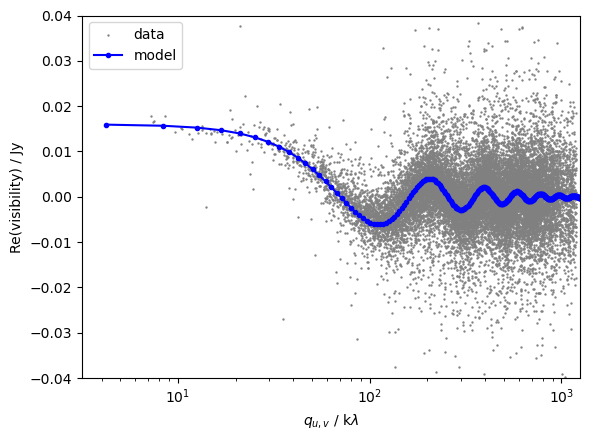

In [225]:
fig, ax = plt.subplots(figsize=(6,4.5))
ax.scatter(ruv/1e3, data['re'], s=0.5, label='data', color='gray')
ax.semilogx(Qzero[1:]/1e3, fth[1:], '.-b', label='model')
ax.set_xlim(None, 1.25e3)
ax.set_ylim(-0.04, 0.04)
ax.legend(frameon=True)
ax.set_xlabel('$q_{u,v}$ / k$\\lambda$')
ax.set_ylabel('Re(visibility) / Jy')
fig.tight_layout()
fig.savefig('../doc/model.png', dpi=150)

Finally, add a phase shift to the model.

This has little purpose here, since the plot above is only the real part.

In [14]:
dra = 0.0001
ddec = 0.0001

srt = np.argsort(Qnk)

vis = np.interp(ruv, Qnk[srt], fth[srt])
rot = data['u']*np.pi*2*dra + data['v']*np.pi*2*ddec
# vis = vis * np.exp(1j*rot)